# Импорты

In [ ]:
import os
import torch
import numpy as np
import torchvision
from tqdm import tqdm
import torch.nn as nn
from matplotlib import gridspec
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Country211
from sklearn.metrics import classification_report
from lab4.resnet import *

# Отрисовка результатов

In [ ]:
def show_dependencies(num_layers, train_results, test_results):
    plt.figure(figsize=(10, 6))
    plt.plot(num_layers, test_results, marker='o', label='Test Results', color='b')
    plt.plot(num_layers, train_results, marker='o', label='Train Results', color='g')
    plt.title('Зависимость тестовых и тренировочных результатов от количества слоев')
    plt.xlabel('Количество слоев (num_layers)')
    plt.ylabel('Результаты')
    plt.xticks(num_layers)
    plt.grid(True)
    plt.legend()

def get_loss_graphic(train_loss_arr, train_loss_arr_cut):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.title('Кривая обучения в зависимости от обрезки')
    plt.plot(train_loss_arr, label='Трейн без обрезки')
    plt.plot(train_loss_arr_cut, label='Трейн с обрезкой')
    plt.legend()

# Выбираем набор данных

In [ ]:
# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True,
                                                  transform=transforms.Compose([transforms.ToTensor(), ]))

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True,
                                                 transform=transforms.Compose([transforms.ToTensor(), ]))

100%|██████████| 26421880/26421880 [00:02<00:00, 12124684.32it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271563.38it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5078920.89it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3670283.36it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Выбираем устройство для исполнения

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# ResNet-18

In [ ]:
def get_results(use_batch_norm, init_weights):
    num_layers = range(2, 12, 2)
    results_train = []
    results_test = []
    for num in tqdm(num_layers, desc="Перебираем разное количество слоев"):
        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam
        model_resnet = ResNet18(block=BasicBlock, num_blocks=num, num_classes=10, use_batch_norm=use_batch_norm, init_weights=init_weights).to(device)
        trainer(count_of_epoch=2,
                batch_size=64,
                dataset=train_dataset,
                model=model_resnet,
                loss_function=loss_function,
                optimizer=optimizer,
                lr=0.001,
                callback=None)

        macro_avg_train, _ = tester(model_resnet, train_dataset, loss_function)
        results_train.append(macro_avg_train)

        macro_avg_test, _ = tester(model_resnet, test_dataset, loss_function)
        results_test.append(macro_avg_test)
    return num_layers, results_train, results_test

## Без инициализации весов и батчевой нормализации

Перебираем разное количество слоев: 100%|██████████| 5/5 [09:51<00:00, 118.23s/it]


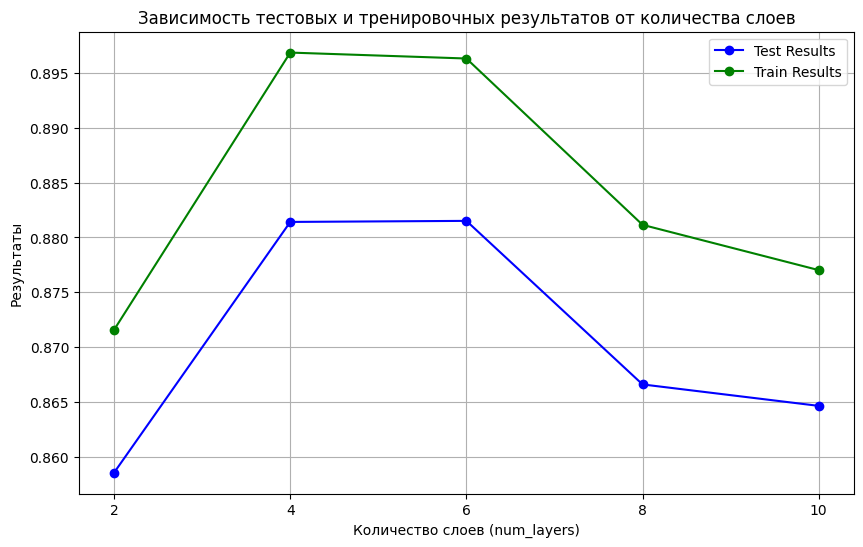

In [ ]:
num_layers, results_train, results_test = get_results(False, False)
show_dependencies(num_layers, results_train, results_test)

## С инициализацией весов и без батчевой нормализации

Перебираем разное количество слоев: 100%|██████████| 5/5 [10:59<00:00, 131.97s/it]


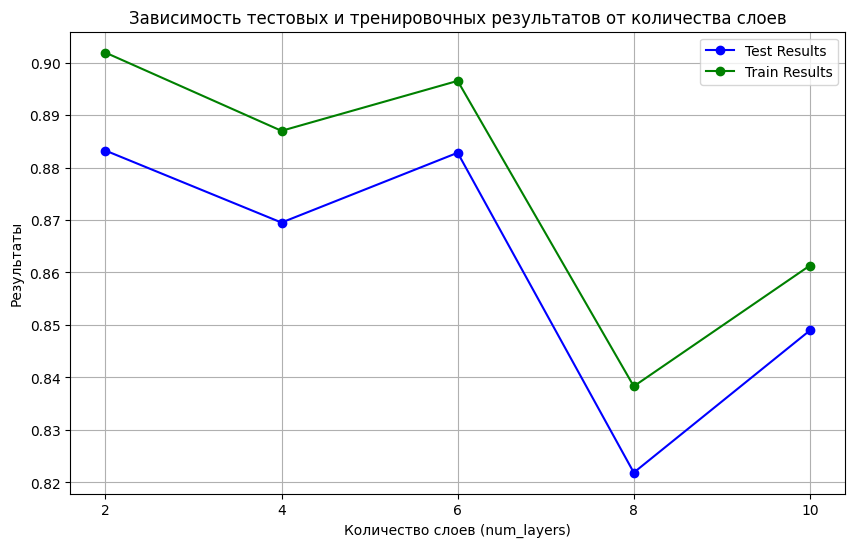

In [ ]:
num_layers, results_train, results_test = get_results(True, False)
show_dependencies(num_layers, results_train, results_test)

## С инициализацией весов и батчевой нормализацией

Перебираем разное количество слоев: 100%|██████████| 5/5 [11:00<00:00, 132.01s/it]


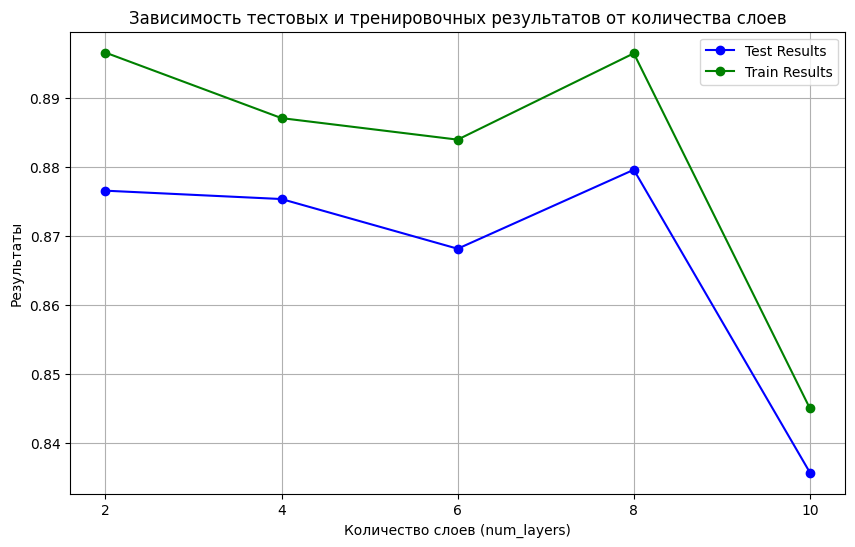

In [ ]:
num_layers, results_train, results_test = get_results(True, True)
show_dependencies(num_layers, results_train, results_test)

### Замечание
 Нужно выбрать архитектуру с наиболее оптимальным наибольшем количество слоев (то есть максимальное количество слоев, при котором сетка еще может обучаться).

 Я не хочу еще раз запускать код, чтобы выбрать оптимальное количество слоев, так как графиков выше более чем достаточно. Выберу оптимально количество слоев = 8

# Прореживание сети

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
model_resnet = ResNet18(block=BasicBlock, num_blocks=8, num_classes=10, use_batch_norm=True, init_weights=True).to(device)
model_resnet, train_loss_arr = trainer(count_of_epoch=4,
                batch_size=64,
                dataset=train_dataset,
                model=model_resnet,
                loss_function=loss_function,
                optimizer=optimizer,
                lr=0.001,
                callback=None
)
macro_avg_test, _ = tester(model_resnet, test_dataset, loss_function)

In [ ]:
model_resnet.prune(threshold=0.3)
model_resnet, train_loss_arr_cut = trainer(count_of_epoch=4,
                batch_size=64,
                dataset=train_dataset,
                model=model_resnet,
                loss_function=loss_function,
                optimizer=optimizer,
                lr=0.001,
                callback=None
)
macro_avg_test_cut, _= tester(model_resnet, test_dataset, loss_function)

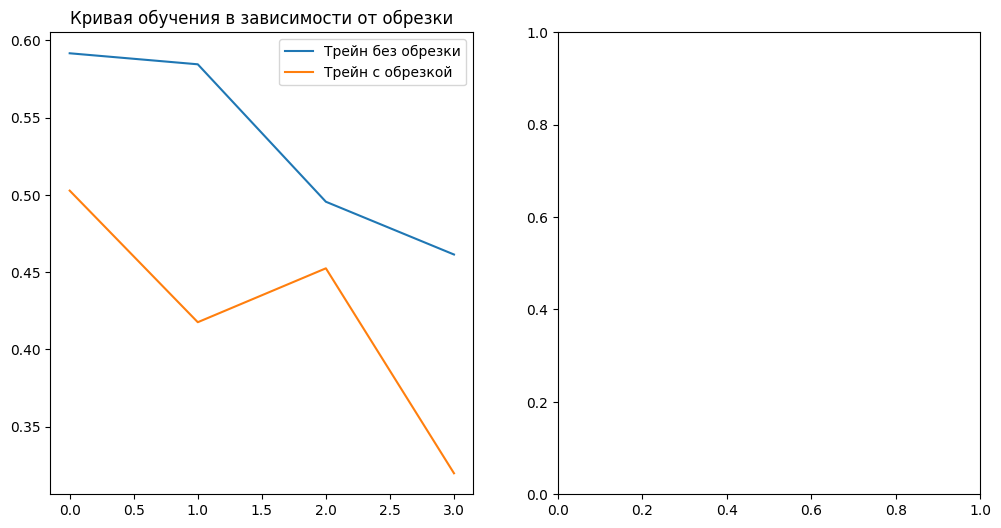

In [ ]:
get_loss_graphic(train_loss_arr, train_loss_arr_cut)